In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import nltk.sentiment
import re

import warnings
warnings.filterwarnings('ignore')

from prepare import prep_readme_data
import model
import nltk.sentiment

from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=14)
plt.style.use('seaborn-darkgrid')

In [3]:
movie_title = pd.read_csv("IMDb movies.csv")

In [4]:
# What is are biggest markets in terms of movie production? 

movie_title.groupby("country").title.count().sort_values(ascending=False).nlargest(5)

country
USA       27490
India      5540
UK         3869
France     2975
Japan      2850
Name: title, dtype: int64

In [5]:
# What year did most movies get published?

movie_title.groupby("date_published").title.count().nlargest(10)

date_published
2010    111
1999    105
2008    101
1997     92
1985     90
1996     89
2009     89
1989     85
2011     85
1987     84
Name: title, dtype: int64

In [6]:
# What data range do we have? 

movie_title.date_published.min(), movie_title.date_published.max()

('1906-12-26', '2020-05-22')

In [7]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

For the purposes of this project, we will only look to use movies from the US. If the opportunity to scale up the project is possible, then we will add additional countries.

In [8]:
df = movie_title[(movie_title.country == "USA")]

In [9]:
# we see that we have a couple of missing values.
df.isnull().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      0
language                   307
director                    28
writer                     191
production_company        1139
actors                      22
description                 76
avg_vote                     0
votes                        0
budget                   17213
usa_gross_income         19940
worlwide_gross_income    19710
metascore                21145
reviews_from_users         279
reviews_from_critics      1728
dtype: int64

**Steps for Removing Null Values**:

1. The movie description will be a large part indicator or similarity, and as such, I want movies that have a description. I will drop any null values in this column
1. I will explore that language column, as I suspect at this moment that these shoud be all inglish
1. Similarly to the description, the director would play a big influence and as such I am thinking of dropping all null values from this column
1. While the meta score value would be really useful - there are too many missing values, and as such I will drop this column. Same for the `reviews_from_critics`
1. Might be able to impude a value for the missing `reviews_from_users`
1. I might be able to find the missing writers from the other IMBD file


In [10]:
# Given that hte majority of the movies are exclusively English, and we know that we are only looking at movies
# made in the US, I can speculate that it is very likely these movies were at least partially made in english
# As such, I will impode the missing values

df.language.value_counts()

English                               23976
English, Spanish                        695
English, French                         440
English, German                         198
English, Italian                        195
                                      ...  
English, Afrikaans, Xhosa                 1
English, Icelandic, Italian               1
English, Russian, Esperanto               1
English, Japanese, German, Chinese        1
English, Russian, Korean                  1
Name: language, Length: 629, dtype: int64

In [11]:
df.language = df.language.fillna("English")

In [12]:
# remove nulls from director and description

df = df[df.description.notnull()]

In [13]:
df = df[df.director.notnull()]

In [14]:
df = df[df.writer.notnull()]

In [15]:
# What is the avg budget for all movies so that we can use it to impude values?

df.budget = df.budget.fillna("$ 0")

In [16]:
df = df[~df.budget.str.contains("ESP")]

df = df[~df.budget.str.contains("GBP")]

df = df[~df.budget.str.contains("CAD")]

df = df[~df.budget.str.contains("PYG")]

df = df[~df.budget.str.contains("AUD")]

df = df[~df.budget.str.contains("EUR")]

df = df[~df.budget.str.contains("RUR")]

In [17]:
avg_budget = df.budget.str.replace("$", '').astype(int).mean()

In [18]:
df.budget = df.budget.str.replace("$", '').astype(int)

In [19]:
df.budget = df.budget.replace(0, avg_budget)

In [20]:
# We will do something similar for US gross income

median_income = df[(df.usa_gross_income.notnull()) & (df.usa_gross_income.str.contains("$", regex=False))].usa_gross_income.str.replace("$", '').astype(int).median()

In [21]:
df.usa_gross_income = df.usa_gross_income.fillna("$ 0")

In [22]:
df.usa_gross_income = (
    df[df.usa_gross_income.str.contains("$", regex=False)]
    .usa_gross_income.str.replace("$", '')
    .astype(int)
    .replace(0, median_income)
)

In [23]:
# Remove columns with too many null values

df = df.drop(columns=["worlwide_gross_income", "metascore", "reviews_from_users", "reviews_from_critics"])

In [24]:
# Drop any remaining null values

df = df.dropna()

In [25]:
# Now we have no null values, and still have over 26000 movie titles

df.isnull().sum(), df.shape

(imdb_title_id         0
 title                 0
 original_title        0
 year                  0
 date_published        0
 genre                 0
 duration              0
 country               0
 language              0
 director              0
 writer                0
 production_company    0
 actors                0
 description           0
 avg_vote              0
 votes                 0
 budget                0
 usa_gross_income      0
 dtype: int64, (26102, 18))

## NLP Exploration

In [26]:
df_prep = prep_readme_data(df, "description")

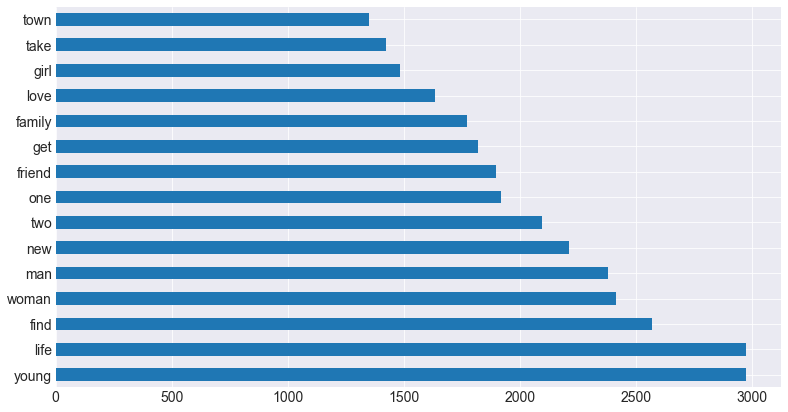

In [27]:
# What are the most common words in movie descriptions?

all_words = clean(' '.join(df.description))

pd.Series(all_words).value_counts().head(15).plot.barh()


### Common words by genre?

In [28]:
# What are the top most common genres?

df.genre.value_counts().head(5)

Drama             2294
Comedy            1810
Comedy, Drama      953
Horror             947
Drama, Romance     886
Name: genre, dtype: int64

In [29]:
drama = clean(' '.join(df[df.genre == "Drama"].description))
comedy = clean(' '.join(df[df.genre == "Comedy"].description))
comedy_drama = clean(' '.join(df[df.genre == "Comedy, Drama"].description))
horror = clean(' '.join(df[df.genre == "Horror"].description))
drame_romance = clean(' '.join(df[df.genre == "Drama, Romance"].description))

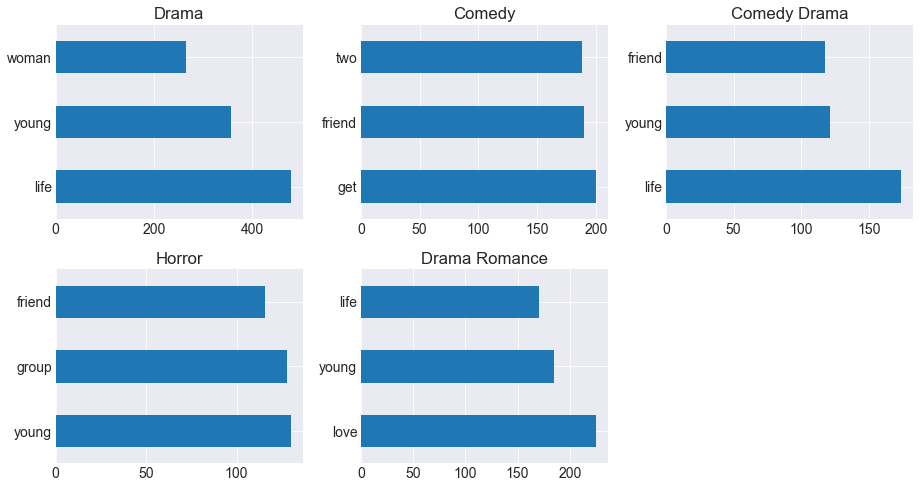

In [30]:
plt.subplot(2,3,1)
pd.Series(drama).value_counts().head(3).plot.barh()
plt.title("Drama")
plt.subplot(2,3,2)
pd.Series(comedy).value_counts().head(3).plot.barh()
plt.title("Comedy")
plt.subplot(2,3,3)
pd.Series(comedy_drama).value_counts().head(3).plot.barh()
plt.title("Comedy Drama")
plt.subplot(2,3,4)
pd.Series(horror).value_counts().head(3).plot.barh()
plt.title("Horror")
plt.subplot(2,3,5)
pd.Series(drame_romance).value_counts().head(3).plot.barh()
plt.title("Drama Romance")

plt.tight_layout()
plt.show()


### Common words throughout time?

In [31]:
def most_frequent_bigram(s: pd.Series) -> str:
    # your code might be more or less complicated here, depending on how much
    # text prep you've already done or more you want to do in this function
    words = clean(' '.join(s))
    most_common_bigram = pd.Series(nltk.bigrams(words)).value_counts().head(1).index
    return most_common_bigram

In [32]:
df.date_published = pd.to_datetime(df.date_published)

In [33]:
most_common_bigrams = df.set_index('date_published').resample('Y').description.agg([most_frequent_bigram, "count"])

In [34]:
most_common_bigrams["most_frequent_bigram"][0]

('antony', 'ulimately')

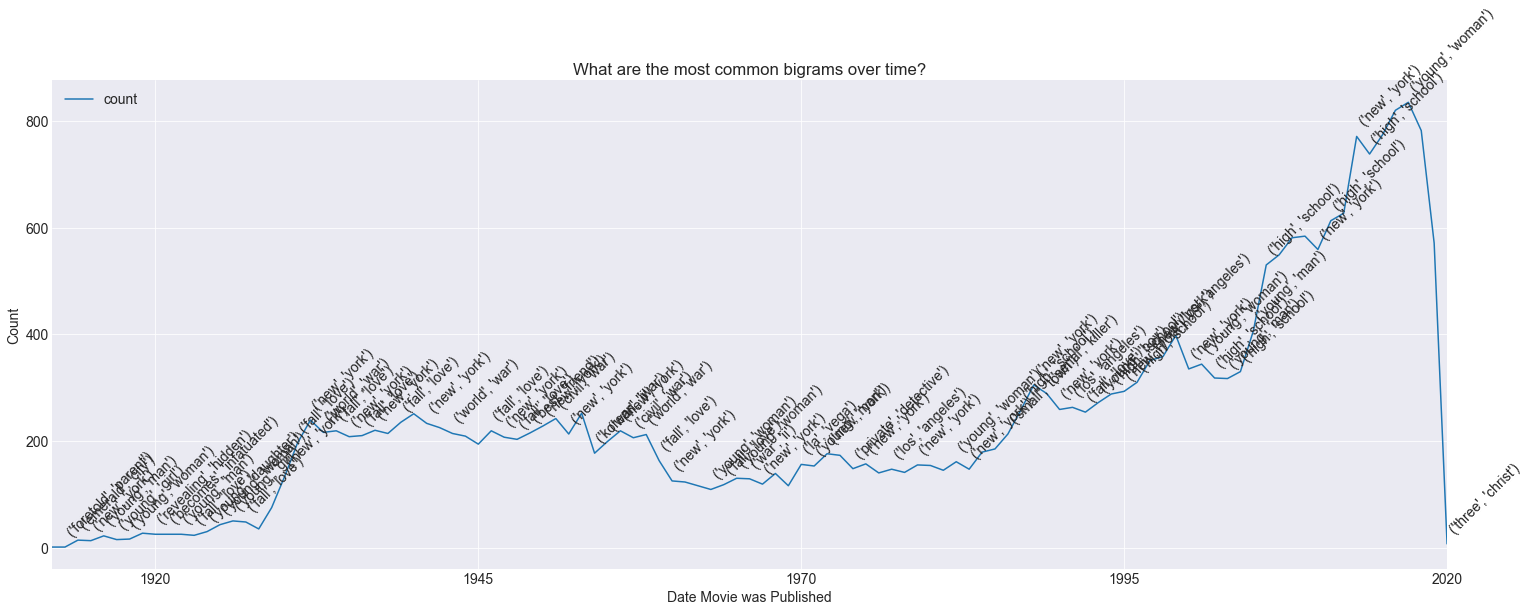

In [35]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams over time?")
plt.ylabel("Count")
plt.xlabel("Date Movie was Published")
for i in range(1, most_common_bigrams.shape[0]):
    if most_common_bigrams["most_frequent_bigram"][i] != most_common_bigrams["most_frequent_bigram"][i-1]:
        ax.text(f"{most_common_bigrams.index[i]}", most_common_bigrams["count"][i] + 20,  f"{most_common_bigrams.most_frequent_bigram[i]}", rotation = 45)

### Common bigrams in high voted movies vs low?

In [36]:
most_common_bigrams = df.groupby("avg_vote").description.agg([most_frequent_bigram, "count"])

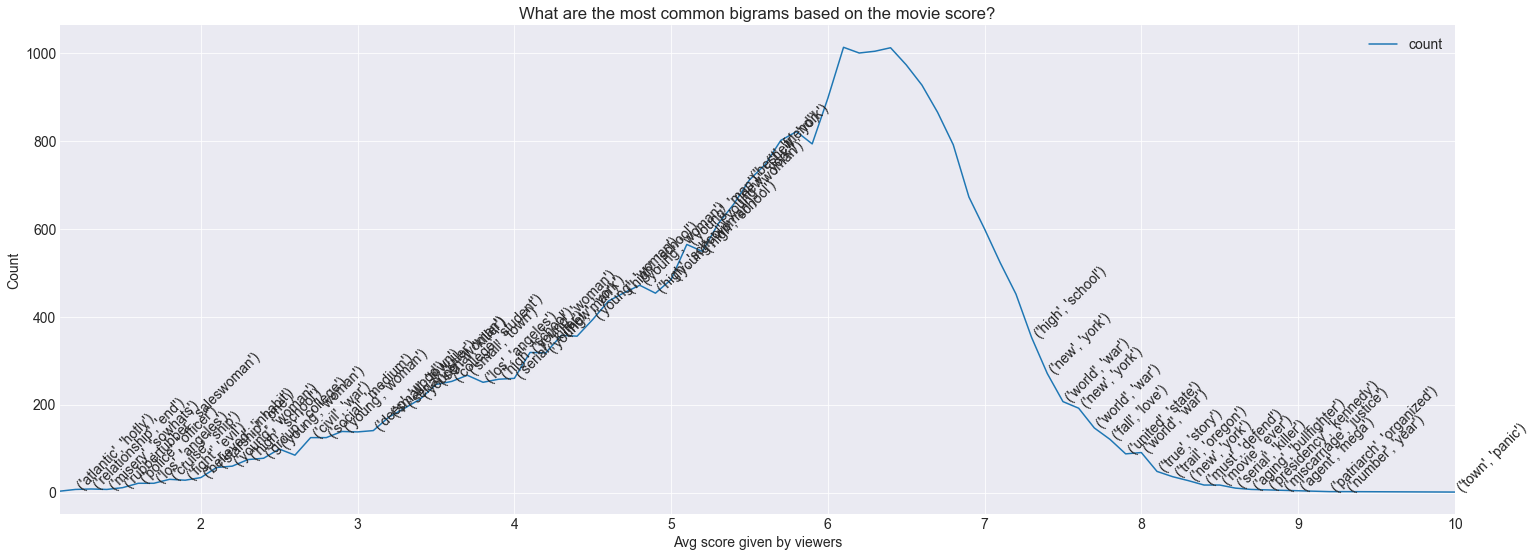

In [37]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams based on the movie score?")
plt.ylabel("Count")
plt.xlabel("Avg score given by viewers")
for i in range(1, most_common_bigrams.shape[0]):
    if most_common_bigrams["most_frequent_bigram"].iloc[i] != most_common_bigrams["most_frequent_bigram"].iloc[i-1]:
        ax.text(most_common_bigrams.index[i], most_common_bigrams["count"].iloc[i],  f"{most_common_bigrams.most_frequent_bigram.iloc[i]}", rotation = 45)

### Common words in high grossing movies vs low?

In [38]:
df["usa_gross_bin"] = pd.cut(df.usa_gross_income, 10, labels=[1,2,3,4,5,6,7,8,9, 10])

In [39]:
most_common_bigrams = df.groupby("usa_gross_bin").description.agg([most_frequent_bigram, "count"])

In [40]:
df[df["usa_gross_bin"] == 10]

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin
65123,tt2488496,Star Wars: Episode VII - The Force Awakens,Star Wars: Episode VII - The Force Awakens,2015,2015-12-17,"Action, Adventure, Sci-Fi",138,USA,English,J.J. Abrams,...,"Three decades after the Empire's defeat, a new...",7.9,800030,245000000.0,936662225.0,three decades after the empires defeat a new t...,"[three, decades, after, the, empires, defeat, ...",three decade after the empire defeat a new thr...,three decade empire defeat new threat arises m...,10
71243,tt4154796,Avengers: Endgame,Avengers: Endgame,2019,2019-04-25,"Action, Adventure, Drama",181,USA,"English, Japanese, Xhosa, German","Anthony Russo, Joe Russo",...,After the devastating events of,8.5,602792,356000000.0,858373000.0,after the devastating events of,"[after, the, devastating, events, of]",after the devastating event of,devastating event,10


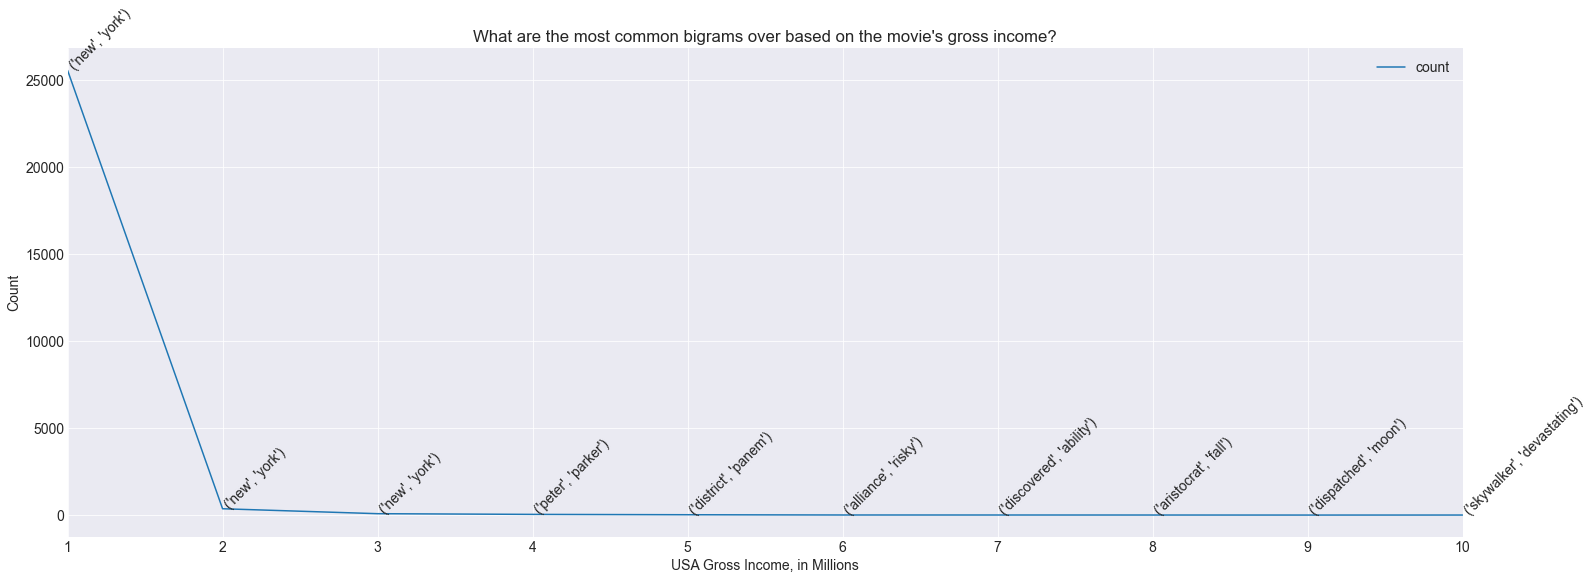

In [41]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams over based on the movie's gross income?")
plt.ylabel("Count")
plt.xlabel("USA Gross Income, in Millions")
for i in most_common_bigrams.index:
    ax.text(i-1, most_common_bigrams["count"][i],  f"{most_common_bigrams.most_frequent_bigram[i]}", rotation = 45)

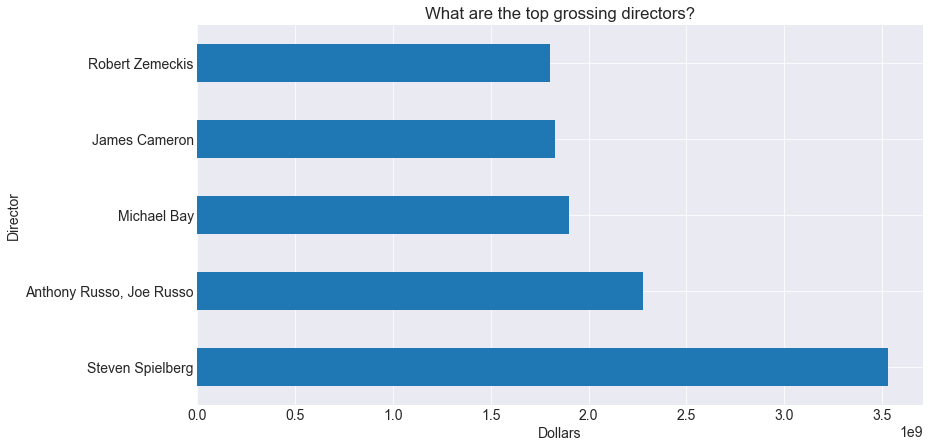

In [99]:
# what are highest grossing directors of all times?


df.groupby("director").usa_gross_income.sum().sort_values(ascending=False).head(5).plot.barh()
plt.title("What are the top grossing directors?")
plt.xlabel("Dollars")
plt.ylabel("Director")
plt.show()

Text(0, 0.5, 'Genre')

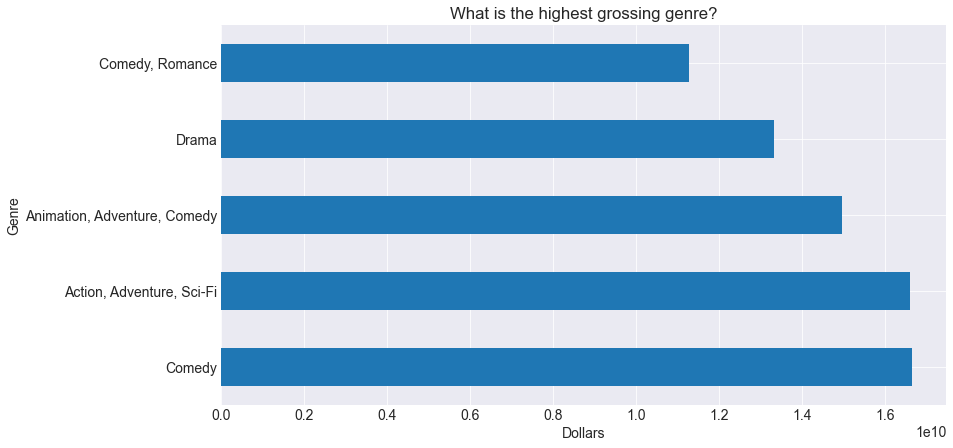

In [106]:
# what are the top genres by genre?

df.groupby("genre").usa_gross_income.sum().sort_values(ascending=False).head(5).plot.barh()
plt.title("What is the highest grossing genre?")
plt.xlabel("Dollars")
plt.ylabel("Genre")

In [126]:
df[df.genre == "Animation, Drama, Sci-Fi"]

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,avg_vote,votes,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin,cluster
53180,tt1196334,After Last Season,After Last Season,2009,2009-06-05,"Animation, Drama, Sci-Fi",93,USA,English,Mark Region,...,1.6,7767,30000.0,5548375.0,two neurology students create a telepathy expe...,"[two, neurology, students, create, a, telepath...",two neurology student create a telepathy exper...,two neurology student create telepathy experim...,1,9


Text(0, 0.5, 'Director')

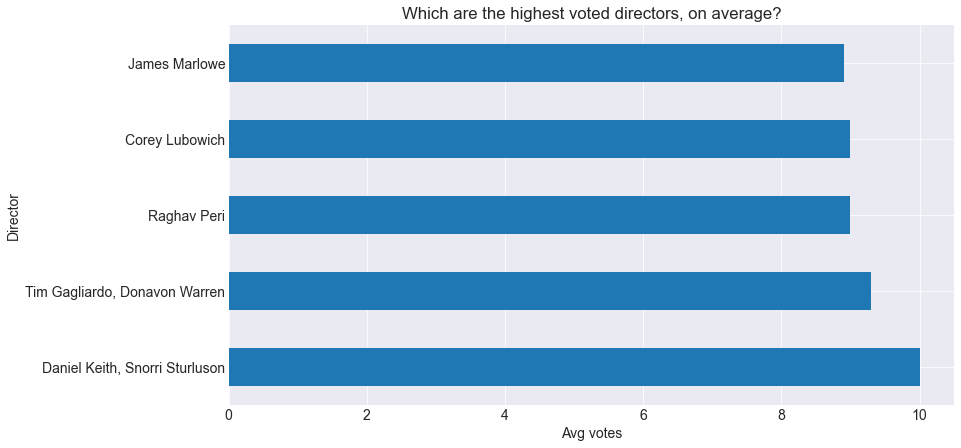

In [119]:
# what are the highest voted directors?

df.groupby("director").avg_vote.mean().sort_values(ascending=False).head(5).plot.barh()
plt.title("Which are the highest voted directors, on average?")
plt.xlabel("Avg votes")
plt.ylabel("Director")

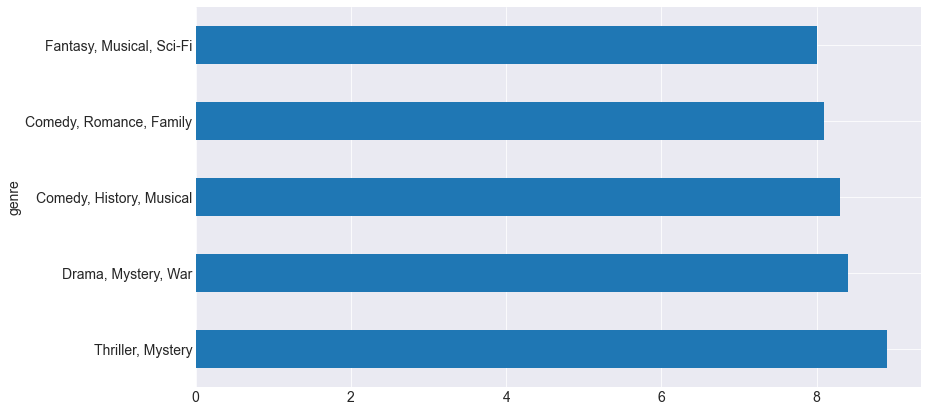

In [118]:
# What are the highest voted genres?

df.groupby("genre").avg_vote.mean().sort_values(ascending=False).head(5).plot.barh()

### Sentiment Analysis

Can sentiment analysis of the movie description help us identify if they are similar movies?

In [161]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()
df["sentiment"] = df.clean_lemmatized.apply(lambda blog: sia.polarity_scores(blog)["compound"])

Text(0, 0.5, 'Genre Name')

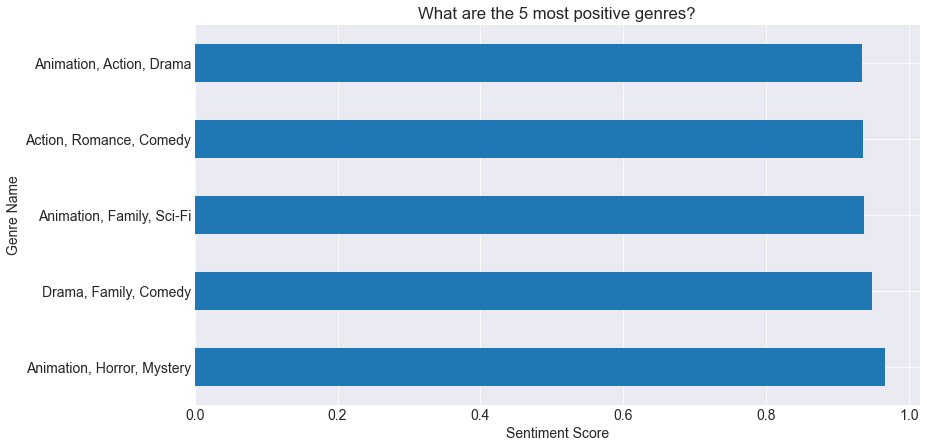

In [169]:
df.groupby("genre").sentiment.mean().sort_values(ascending=False).head(5).plot.barh()
plt.title("What are the 5 most positive genres?")
plt.xlabel("Sentiment Score")
plt.ylabel("Genre Name")

Text(0, 0.5, 'Genre Name')

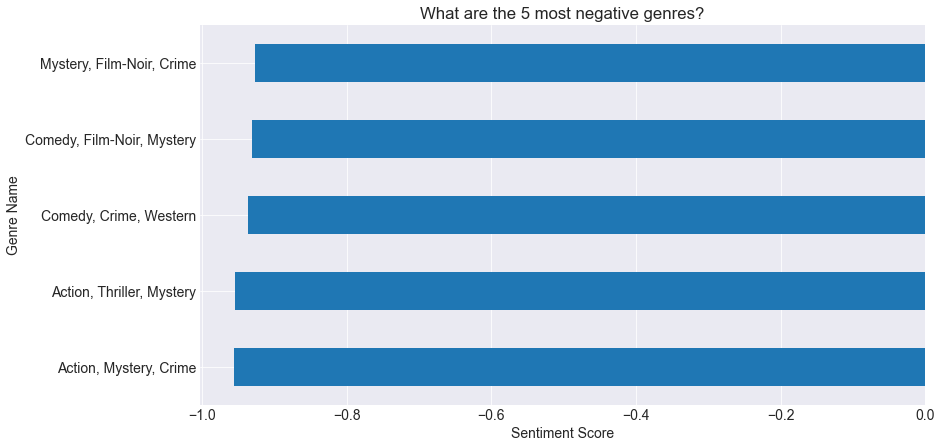

In [172]:
df.groupby("genre").sentiment.mean().sort_values().head(5).plot.barh()
plt.title("What are the 5 most negative genres?")
plt.xlabel("Sentiment Score")
plt.ylabel("Genre Name")

In [176]:
# What is the most positive movie description?

df.nlargest(1, "sentiment").description.values

array(['After winning money gambling in Reno, George enjoys a streak of luck that brings him happiness and success. He dates a beautiful woman and works with a friend in business and then his luck changes while comedy ensues.'],
      dtype=object)

In [177]:
# What is the most negative movie description?

df.nsmallest(1, "sentiment").description.values

array(["In Kentucky just after the Civil War, the Hayden-Colby feud leads to Jed Colby being sent to prison for 15 years for murder. The Haydens head for Nevada and when Colby gets out of prison he heads there also seeking revenge. The head of the Hayden family tries to avoid more killing but the inevitable showdown has to occur, complicated by Lynn Hayden and Ellen Colby's plans to marry."],
      dtype=object)

It seems that overall, animation movies tend to have more positive descriptions. This makes sense, as most animation movies tend to target a younger audience, or a family audience. It should be noted that we are using a sentiment analysis that was largely developed for social media analysis, and as such, it was trained on a a very different corpus. 

# Modeling

For modeling, we will most likely need to do a bag of words, and then use those features are a metric for clustering

The simple recommendation model:

* We will look to do a traditional clustering, by looking at features that are already numerical. These features will be:
    * Year release
    * Run time
    * Avg vote
    * Do a `One Hot Encoder` for genre
  
A more advance model would look to use NLP practices to actually model based on the description, on top of some of the other features previously mentioned.
 

### Simple Model

Steps:

1. Filter data based on the genre
2. Cluster the data based on `avg_votes`, `usa_gross_income`, `year` and `duration`

In [137]:
df_num = df[["title", "avg_vote", "usa_gross_income", "year", "duration"]]

In [139]:
df_num = df_num.set_index("title")

In [143]:
df_num

,avg_vote,usa_gross_income,year,duration
title,,,,
Cleopatra,5.2,5548375.0,1912,100
"From the Manger to the Cross; or, Jesus of Nazareth",5.7,5548375.0,1912,60
"Home, Sweet Home",5.7,5548375.0,1914,55
The Avenging Conscience: or 'Thou Shalt Not Kill',6.5,5548375.0,1914,78
The Bargain,6.6,5548375.0,1914,70
...,...,...,...,...
Adventures of Aladdin,1.7,5548375.0,2019,87
The Hard Way,4.8,5548375.0,2019,92
The Banana Splits Movie,5.0,5548375.0,2019,89


Text(0.5, 0, 'Movie Duration, in minutes')

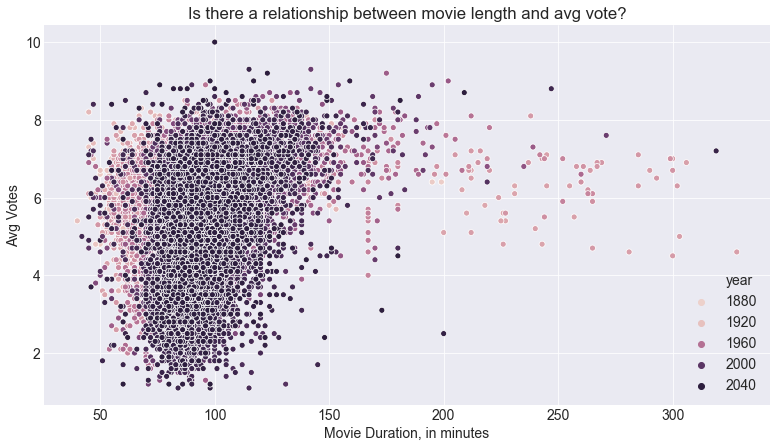

In [146]:
sns.scatterplot(data = df_num, x= "duration", y= "avg_vote", hue="year")
plt.title("Is there a relationship between movie length and avg vote?")
plt.ylabel("Avg Votes")
plt.xlabel("Movie Duration, in minutes")


Interestingly, we see that there is not a very distinct difference between movie length and avg score. It is insteresting, however, that newer movies (post-2000) seem to be, on average, a bit longer. 

Text(0.5, 0, 'USA Gross Income, in dollars')

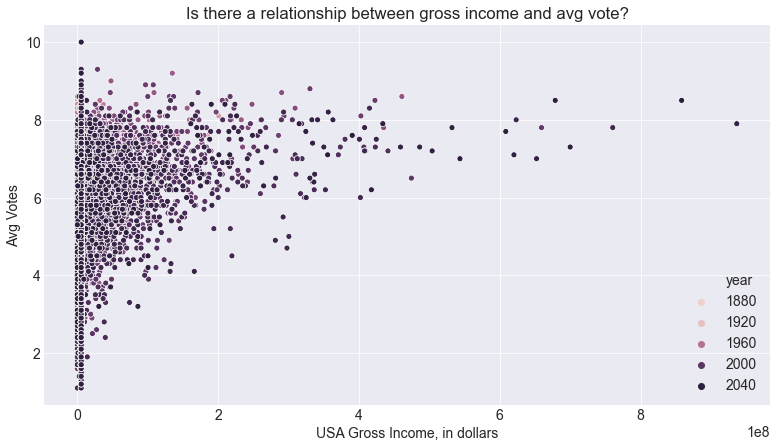

In [155]:
sns.scatterplot(data = df_num, x= "usa_gross_income", y= "avg_vote", hue="year")
plt.title("Is there a relationship between gross income and avg vote?")
plt.ylabel("Avg Votes")
plt.xlabel("USA Gross Income, in dollars")

It also seems that there are not a lot of significant differences between gross income and movie score. This is probably largely influenced by the fact that we had to impude some of the missing income, resulting in some similar results.

In [197]:
# First, we need to scale the data

minmax = MinMaxScaler()

scaled_df = minmax.fit_transform(df_num)

In [259]:
# Create an instance of KMeans 
kmeans = KMeans(n_clusters=50)
# Use fit_predict to cluster the dataset
predictions = kmeans.fit_predict(scaled_df)

In [260]:
df["cluster"] = predictions

In [261]:
df["cluster"] = "cluster_" + df.cluster.astype(str)

-----

#### Test 1

In [350]:
def simple_movie_recommender(df, test):

    is_in_data = ''
    for i in df['title']:
        if test in i :
            is_in_data = True

    if is_in_data == True:
        index = df[df.title == test].index
        
        genre_type = df[df.title == test].genre.values

        cluster = df[df.title == test].cluster.values

        recommended_movies = df[(df.genre.str.contains(genre_type[0])) & (df.cluster.str.contains(cluster[0]))].sort_values(by="avg_vote", ascending=False)
        
        recommended_movies = recommended_movies[recommended_movies.index != index[0]]

        return recommended_movies.head(25)

    else:
        return "Movie Not in the Database"

In [348]:
# Now we test

test = "Toy Story"

In [349]:
simple_movie_recommender(df, test)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,votes,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin,cluster,sentiment
51470,tt1049413,Up,Up,2009,2009-10-09,"Animation, Adventure, Comedy",96,USA,English,"Pete Docter, Bob Peterson",...,869605,175000000.0,293004164.0,seventyeight year old carl fredricksen travels...,"[seventyeight, year, old, carl, fredricksen, t...",seventyeight year old carl fredricksen travel ...,seventyeight year old carl fredricksen travel ...,4,cluster_44,0.6369
25601,tt0103639,Aladdin,Aladdin,1992,1993-12-03,"Animation, Adventure, Comedy",90,USA,English,"Ron Clements, John Musker",...,337867,28000000.0,217350219.0,a kindhearted street urchin and a powerhungry ...,"[a, kindhearted, street, urchin, and, a, power...",a kindhearted street urchin and a powerhungry ...,kindhearted street urchin powerhungry grand vi...,3,cluster_44,0.8720
34846,tt0198781,"Monsters, Inc.","Monsters, Inc.",2001,2002-02-08,"Animation, Adventure, Comedy",92,USA,English,"Pete Docter, David Silverman",...,760249,115000000.0,289916256.0,in order to power the city monsters have to sc...,"[in, order, to, power, the, city, monsters, ha...",in order to power the city monster have to sca...,order power city monster scare child scream ho...,4,cluster_44,-0.7096
43202,tt0382932,Ratatouille,Ratatouille,2007,2007-10-12,"Animation, Adventure, Comedy",111,USA,"English, French","Brad Bird, Jan Pinkava",...,595590,150000000.0,206445654.0,a rat who can cook makes an unusual alliance w...,"[a, rat, who, can, cook, makes, an, unusual, a...",a rat who can cook make an unusual alliance wi...,rat cook make unusual alliance young kitchen w...,3,cluster_44,0.0000
30272,tt0120363,Toy Story 2,Toy Story 2,1999,2000-02-11,"Animation, Adventure, Comedy",92,USA,"English, Arabic, Spanish","John Lasseter, Ash Brannon",...,490724,90000000.0,245852179.0,when woody is stolen by a toy collector buzz a...,"[when, woody, is, stolen, by, a, toy, collecto...",when woody is stolen by a toy collector buzz a...,woody stolen toy collector buzz friend set res...,3,cluster_44,0.7579
30955,tt0126029,Shrek,Shrek,2001,2001-06-29,"Animation, Adventure, Comedy",90,USA,English,"Andrew Adamson, Vicky Jenson",...,576231,60000000.0,267665011.0,a mean lord exiles fairytale creatures to the ...,"[a, mean, lord, exiles, fairytale, creatures, ...",a mean lord exile fairytale creature to the sw...,mean lord exile fairytale creature swamp grump...,3,cluster_44,0.5106
43793,tt0398286,Tangled,Tangled,2010,2011-01-28,"Animation, Adventure, Comedy",100,USA,English,"Nathan Greno, Byron Howard",...,375980,260000000.0,200821936.0,the magically longhaired rapunzel has spent he...,"[the, magically, longhaired, rapunzel, has, sp...",the magically longhaired rapunzel ha spent her...,magically longhaired rapunzel ha spent entire ...,3,cluster_44,0.1027
59548,tt1772341,Wreck-It Ralph,Wreck-It Ralph,2012,2013-02-08,"Animation, Adventure, Comedy",101,USA,English,Rich Moore,...,355094,165000000.0,189422889.0,a video game villain wants to be a hero and se...,"[a, video, game, villain, wants, to, be, a, he...",a video game villain want to be a hero and set...,video game villain want hero set fulfill dream...,3,cluster_44,0.0772
69060,tt3521164,Moana,Moana,2016,2016-12-02,"Animation, Adventure, Comedy",107,USA,English,"Ron Clements, John Musker",...,236171,150000000.0,248757044.0,in ancient polynesia when a terrible curse inc...,"[in, ancient, polynesia, when, a, terrible, cu...",in ancient polynesia when a terrible curse inc...,ancient polynesia terrible curse incurred demi...,3,cluster_44,-0.7579
38103,tt0268380,Ice Age,Ice Age,2002,2002-03-22,"Animation, Adventure, Comedy",81,USA,English,"Chris Wedge, Carlos Saldanha",...,412978,59000000.0,176387405.0,set during the ice age a sabertooth tiger a sl...,"[set, during, the, ice, age, a, sabertooth, ti...",set during the ice age a sabertooth tiger a sl...,set ice age s

------

#### Test 2

In [374]:
def simple_movie_recommender(df, test):

    is_in_data = ''
    for i in df['title']:
        if test == i :
            is_in_data = True

    if is_in_data == True:
        index = df[df.title == test].index
        
        genre_type = df[df.title == test].genre.values

        cluster = df[df.title == test].cluster.values

        recommended_movies = df[(df.genre.str.contains(genre_type[0])) & (df.cluster.str.contains(cluster[0]))].sort_values(by="avg_vote", ascending=False)
        
        recommended_movies = recommended_movies[recommended_movies.index != index[0]]

        return recommended_movies.head(25)

    else:
        return "Movie Not in the Database or Not Spelled Correctly"

In [376]:
test = "Bridesmaids"

In [377]:
simple_movie_recommender(df, test)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,votes,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin,cluster,sentiment
31176,tt0129387,There's Something About Mary,There's Something About Mary,1998,1998-09-25,"Comedy, Romance",119,USA,English,"Bobby Farrelly, Peter Farrelly",...,278399,23000000.0,176484651.0,a man gets a chance to meet up with his dream ...,"[a, man, gets, a, chance, to, meet, up, with, ...",a man get a chance to meet up with his dream g...,man get chance meet dream girl high school eve...,2,cluster_44,-0.2732
44075,tt0405422,The 40 Year Old Virgin,The 40 Year Old Virgin,2005,2005-09-02,"Comedy, Romance",116,USA,"English, Spanish, Japanese",Judd Apatow,...,372126,26000000.0,109449237.0,goaded by his buddies a nerdy guy whos never d...,"[goaded, by, his, buddies, a, nerdy, guy, whos...",goaded by his buddy a nerdy guy who never done...,goaded buddy nerdy guy never done deed find pr...,2,cluster_44,-0.3400
35564,tt0212338,Meet the Parents,Meet the Parents,2000,2000-12-15,"Comedy, Romance",108,USA,"English, Thai, Spanish, Hebrew, French",Jay Roach,...,296907,55000000.0,166244045.0,male nurse greg focker meets his girlfriends p...,"[male, nurse, greg, focker, meets, his, girlfr...",male nurse greg focker meet his girlfriend par...,male nurse greg focker meet girlfriend parent ...,2,cluster_44,-0.7650
43708,tt0396269,Wedding Crashers,Wedding Crashers,2005,2005-07-15,"Comedy, Romance",119,USA,English,David Dobkin,...,318764,40000000.0,209255921.0,john beckwith and jeremy grey a pair of commit...,"[john, beckwith, and, jeremy, grey, a, pair, o...",john beckwith and jeremy grey a pair of commit...,john beckwith jeremy grey pair committed woman...,3,cluster_44,0.7184
47223,tt0478311,Knocked Up,Knocked Up,2007,2007-08-24,"Comedy, Romance",129,USA,English,Judd Apatow,...,336347,30000000.0,148768917.0,for funloving party animal ben stone the last ...,"[for, funloving, party, animal, ben, stone, th...",for funloving party animal ben stone the last ...,funloving party animal ben stone last thing ev...,2,cluster_44,0.4019
43376,tt0386588,Hitch,Hitch,2005,2005-03-11,"Comedy, Romance",118,USA,English,Andy Tennant,...,282447,70000000.0,179495555.0,while helping his latest client woo the woman ...,"[while, helping, his, latest, client, woo, the...",while helping his latest client woo the woman ...,helping latest client woo woman dream professi...,2,cluster_44,0.7920
57214,tt1564367,Just Go with It,Just Go with It,2011,2011-02-11,"Comedy, Romance",117,USA,English,Dennis Dugan,...,206514,80000000.0,103028109.0,on a weekend trip to hawaii a plastic surgeon ...,"[on, a, weekend, trip, to, hawaii, a, plastic,...",on a weekend trip to hawaii a plastic surgeon ...,weekend trip hawaii plastic surgeon convinces ...,2,cluster_44,0.3182
39308,tt0290002,Meet the Fockers,Meet the Fockers,2004,2005-01-28,"Comedy, Romance",115,USA,"English, Spanish, Hebrew",Jay Roach,...,241465,80000000.0,279261160.0,all hell breaks loose when the byrnes family m...,"[all, hell, breaks, loose, when, the, byrnes, ...",all hell break loose when the byrnes family me...,hell break loose byrnes family meet focker fam...,3,cluster_44,-0.7845
37517,tt0256415,Sweet Home Alabama,Sweet Home Alabama,2002,2002-12-20,"Comedy, Romance",108,USA,English,Andy Tennant,...,97134,30000000.0,127223418.0,a young woman whos reinvented herself as a new...,"[a, young, woman, whos, reinvented, herself, a...",a young woman who reinvented herself a a new y...,young woman reinvented new york city socialite...,2,cluster_44,0.0000
48172,tt0762107,I Now Pronounce You Chuck & Larry,I Now Pronounce You Chuck & Larry,2007,2007-09-21,"Comedy, Romance",115,USA,English,Dennis Dugan,...,135023,85000000.0,120059556.0,two straight single brooklyn firefighters pret...,"[two, straight, single, brooklyn, firefighters...",two straight single brooklyn firefighter prete...,two straight single brooklyn firefighte

We see that our function works relatively well. The way the function works is that it looks in the database for the genre and cluster that the `test` title has. It then filters that data using these masks, and returns the top 25 matches of titles that have a similar genre, and at the same time had a similar run-time, release year, avg votes and year (based on the cluster). 

The tool works fairly well, but ceirtainly requires further testing. Some of the abilities I want to implement:

1. If a movie title is duplicated (i.e "Parent Trap"), then it would assume that it is the most recent title. 
1. At the moment, the tool only looks at the first genre. For example, if a movie is categorized as "Action, Adventure, Comedy", the matches are based on containing only "Action". By implementing a series of conditionals, it might be possible to further improve the model's accuracy.

In order to improve the accuracy of the model, I am hoping we can use more advanced NLP techniques to actually group recommendations based on the movie descriptions.

### Complex Model

Steps:

1. Filter data based on genre
1. Cluster the data based on the TFIDF of the description.

In [378]:
from sklearn.cluster import KMeans

In [379]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

In [380]:
tfidfs = tfidf.fit_transform(df.clean_lemmatized)
tfidfs

<26102x29585 sparse matrix of type '<class 'numpy.float64'>'
	with 389280 stored elements in Compressed Sparse Row format>

In [381]:
# Create an instance of KMeans to find seven clusters
kmeans = KMeans(n_clusters=50)
# Use fit_predict to cluster the dataset
predictions = kmeans.fit_predict(tfidfs)


In [382]:
df["cluster_description"] = predictions

In [385]:
df["cluster_description"] = "cluster_" + df.cluster_description.astype(str)

------

#### Test 1

In [388]:
test = "Toy Story"

In [390]:
index = df[df.title == test].index

genre_type = df[df.title == test].genre.values

cluster = df[df.title == test].cluster.values

cluster_desc = df[df.title == test].cluster_description.values

recommended_movies = (
    df[(df.genre.str.contains(genre_type[0])) 
       & (df.cluster_description.str.contains(cluster_desc[0]))]
    .sort_values(by="avg_vote", ascending=False)
)

recommended_movies = recommended_movies[recommended_movies.index != index[0]]

recommended_movies

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin,cluster,sentiment,cluster_description
51470,tt1049413,Up,Up,2009,2009-10-09,"Animation, Adventure, Comedy",96,USA,English,"Pete Docter, Bob Peterson",...,1.750000e+08,293004164.0,seventyeight year old carl fredricksen travels...,"[seventyeight, year, old, carl, fredricksen, t...",seventyeight year old carl fredricksen travel ...,seventyeight year old carl fredricksen travel ...,4,cluster_44,0.6369,cluster_21
43202,tt0382932,Ratatouille,Ratatouille,2007,2007-10-12,"Animation, Adventure, Comedy",111,USA,"English, French","Brad Bird, Jan Pinkava",...,1.500000e+08,206445654.0,a rat who can cook makes an unusual alliance w...,"[a, rat, who, can, cook, makes, an, unusual, a...",a rat who can cook make an unusual alliance wi...,rat cook make unusual alliance young kitchen w...,3,cluster_44,0.0000,cluster_21
69060,tt3521164,Moana,Moana,2016,2016-12-02,"Animation, Adventure, Comedy",107,USA,English,"Ron Clements, John Musker",...,1.500000e+08,248757044.0,in ancient polynesia when a terrible curse inc...,"[in, ancient, polynesia, when, a, terrible, cu...",in ancient polynesia when a terrible curse inc...,ancient polynesia terrible curse incurred demi...,3,cluster_44,-0.7579,cluster_21
38103,tt0268380,Ice Age,Ice Age,2002,2002-03-22,"Animation, Adventure, Comedy",81,USA,English,"Chris Wedge, Carlos Saldanha",...,5.900000e+07,176387405.0,set during the ice age a sabertooth tiger a sl...,"[set, during, the, ice, age, a, sabertooth, ti...",set during the ice age a sabertooth tiger a sl...,set ice age sabertooth tiger sloth wooly mammo...,2,cluster_44,-0.3182,cluster_21
15178,tt0069289,Snoopy Come Home,Snoopy Come Home,1972,1972-08-09,"Animation, Adventure, Comedy",81,USA,English,Bill Melendez,...,4.784118e+06,5548375.0,when snoopy receives a letter from a girl name...,"[when, snoopy, receives, a, letter, from, a, g...",when snoopy receives a letter from a girl name...,snoopy receives letter girl named lila hospita...,1,cluster_30,0.0000,cluster_21
38479,tt0275847,Lilo & Stitch,Lilo & Stitch,2002,2002-10-18,"Animation, Adventure, Comedy",85,USA,"English, Hawaiian","Dean DeBlois, Chris Sanders",...,8.000000e+07,145794338.0,a hawaiian girl adopts an unusual pet who is a...,"[a, hawaiian, girl, adopts, an, unusual, pet, ...",a hawaiian girl adopts an unusual pet who is a...,hawaiian girl adopts unusual pet actually noto...,2,cluster_44,-0.2960,cluster_21
39767,tt0298148,Shrek 2,Shrek 2,2004,2004-07-02,"Animation, Adventure, Comedy",93,USA,English,"Andrew Adamson, Kelly Asbury",...,1.500000e+08,441226247.0,princess fionas parents invite her and shrek t...,"[princess, fionas, parents, invite, her, and, ...",princess fionas parent invite her and shrek to...,princess fionas parent invite shrek dinner cel...,5,cluster_20,0.6486,cluster_21
10351,tt0055254,One Hundred and One Dalmatians,One Hundred and One Dalmatians,1961,1961-12-22,"Animation, Adventure, Comedy",79,USA,English,"Clyde Geronimi, Hamilton Luske",...,4.000000e+06,144880014.0,when a litter of dalmatian puppies are abducte...,"[when, a, litter, of, dalmatian, puppies, are,...",when a litter of dalmatian puppy are abducted ...,litter dalmatian puppy abducted minion cruella...,2,cluster_48,-0.5106,cluster_21
22352,tt0092752,The Chipmunk Adventure,The Chipmunk Adventure,1987,1991-08-01,"Animation, Adventure, Comedy",77,USA,English,Janice Karman,...,4.784118e+06,6804312.0,the chipmunks compete with the chipettes in a ...,"[the, chipmunks, compete, with, the, chipettes...",the chipmunk compete with the chipettes in a r...,chipmunk compete chipettes round world race,1,cluster_38,0.0000,cluster_21
14255,tt0066817,Bedknobs and Broomsticks,Bedknobs and Broomsticks,1971,1972-07-07,"Animation, Adventure, Comedy",117,USA,"English, German",Robert Stevenson,...,2.000000e+07,5548375.0,an apprentice witch three kids a